In [83]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
sns.set()

In [5]:
columns = ['id', 'date'] + [f'{x//4:02d}:{(x%4)*15:02d}' for x in range(96)] + ['meters', 'total', 'house', 'city', 'city_code', 'street', 'city_code2']
dtypes = [str, str] + [np.float32]*96 + [np.int32, np.int32, np.int32, str, np.int32, str, np.int32]
dtypes = {col: t for col, t in zip(columns,dtypes)}
dirty_df = pd.read_csv('./raw_data/ITF_meters.csv', encoding='windows-1255')
dirty_df.columns = columns
dirty_df.head()

C:\Users\Chapanin\AppData\Local\Temp\ipykernel_21060\290110311.py:4: DtypeWarning: Columns (2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,39,43,44,45,48,51,68,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,100) have mixed types. Specify dtype option on import or set low_memory=False.
  dirty_df = pd.read_csv('./raw_data/ITF_meters.csv', encoding='windows-1255')


,id,date,00:00,00:15,00:30,00:45,01:00,01:15,01:30,01:45,...,23:15,23:30,23:45,meters,total,house,city,city_code,street,city_code2
0,702553279,01/01/2021,5.1280,5.2570,5.2220,5.1600,5.2260,5.2880,5.5030,5.1320,...,8.4450,8.6010,8.4100,3,974,12,מודיעין מכבים רעות,1932,ראל מרדכי גור,1200
1,702553279,02/01/2021,8.6910,8.3190,8.6320,8.5030,8.5340,8.4450,8.6320,8.5970,...,6.3150,6.3150,6.1950,3,706,12,מודיעין מכבים רעות,1932,ראל מרדכי גור,1200
2,702553279,03/01/2021,6.3780,6.3510,6.3150,6.1950,6.3190,6.4720,6.2220,6.1950,...,6.6280,6.2570,6.6320,3,1280,12,מודיעין מכבים רעות,1932,ראל מרדכי גור,1200
3,702553279,04/01/2021,6.4090,6.2840,6.5380,6.4760,6.4100,6.2220,6.4140,6.4130,...,4.0690,3.9720,4.1600,3,1076,12,מודיעין מכבים רעות,1932,ראל מרדכי גור,1200
4,702553279,05/01/2021,4.0070,4.1320,4.0970,3.9100,4.3190,3.8820,4.0030,4.0960,...,3.9760,4.1600,4.0970,3,937,12,מודיעין מכבים רעות,1932,ראל מרדכי גור,1200


In [6]:
def _map(x):
    if type(x) == str:
        if x == '.':
            return 0
        return x.replace(',', '')
    return x

for column in dirty_df.columns:
    dirty_df[column] = [_map(x) for x in dirty_df[column].values]
dirty_df = dirty_df.astype(dtypes)

In [7]:
id_columns = columns[:2]+columns[98:]
new_df = pd.melt(dirty_df, id_vars=id_columns, var_name='time', value_name='consumption')
new_df['timestamp'] = pd.to_datetime(new_df.date +' ' + new_df.time, format='%d/%m/%Y %H:%M')
new_df = new_df.drop(['date', 'time'], axis=1)
new_df.to_pickle('clean.pkl')

In [8]:
new_df = pd.read_pickle('clean.pkl')
new_df.head()

,id,meters,total,house,city,city_code,street,city_code2,consumption,timestamp
0,702553279,3,974,12,מודיעין מכבים רעות,1932,ראל מרדכי גור,1200,5.128,2021-01-01
1,702553279,3,706,12,מודיעין מכבים רעות,1932,ראל מרדכי גור,1200,8.691,2021-01-02
2,702553279,3,1280,12,מודיעין מכבים רעות,1932,ראל מרדכי גור,1200,6.378,2021-01-03
3,702553279,3,1076,12,מודיעין מכבים רעות,1932,ראל מרדכי גור,1200,6.409,2021-01-04
4,702553279,3,937,12,מודיעין מכבים רעות,1932,ראל מרדכי גור,1200,4.007,2021-01-05


In [10]:
print(f'HOMES: {new_df.id.nunique()}. DAYS: {new_df.timestamp.dt.date.nunique()}. CITIES: {new_df.city.nunique()}')

HOMES: 421. DAYS: 763. CITIES: 3


In [95]:
df = new_df[['id', 'timestamp', 'consumption', 'total', 'city']]
id_df = new_df[['id', 'meters', 'house', 'city', 'city_code', 'street']].drop_duplicates().set_index('id')
id_df.head(1)

,meters,house,city,city_code,street
id,,,,,
702553279,3,12,מודיעין מכבים רעות,1932,ראל מרדכי גור


In [96]:
day_df = pd.DataFrame(df[(df.timestamp.dt.hour == 0) & (df.timestamp.dt.minute == 0)])

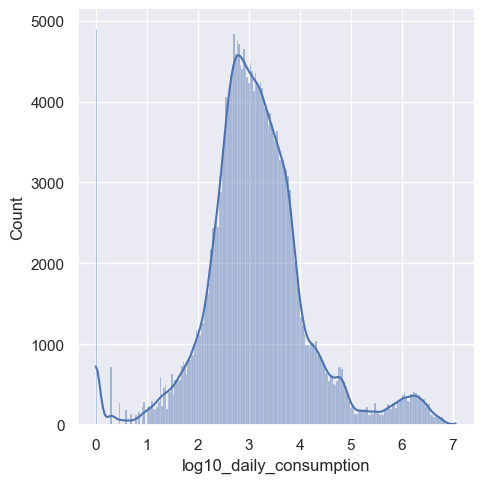

In [97]:
day_df['log10_daily_consumption'] = np.log10(day_df.total + 1)
sns.displot(day_df.log10_daily_consumption, kde=True)

C:\Users\Chapanin\AppData\Local\Temp\ipykernel_21060\1184926158.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  gr = day_df.groupby('id').mean()


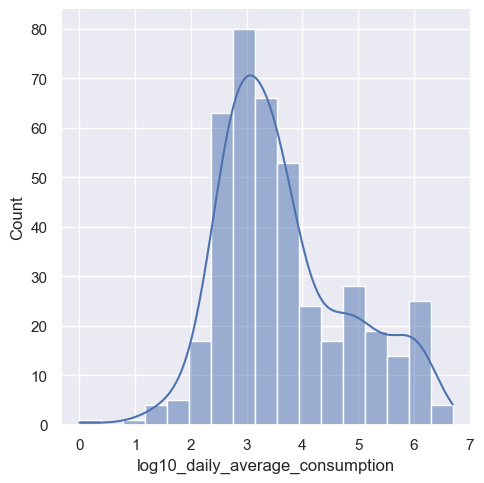

In [98]:
gr = day_df.groupby('id').mean()
gr['log10_daily_average_consumption'] = np.log10(gr.total + 1)
sns.displot(gr.log10_daily_average_consumption, kde=True)

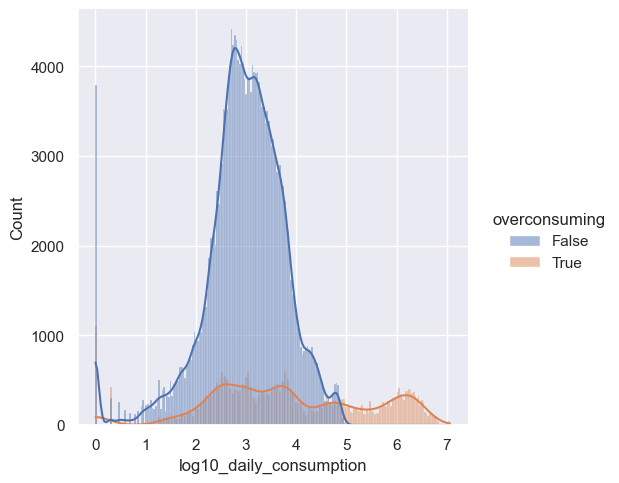

In [99]:
bad_buildings = set(day_df[day_df.log10_daily_consumption > 5].id.unique())
day_df['overconsuming'] = day_df.id.map(lambda x: x in bad_buildings)
sns.displot(data=day_df, x='log10_daily_consumption', kde=True, hue='overconsuming')

In [129]:
current = pd.DataFrame(day_df[day_df.overconsuming == False])

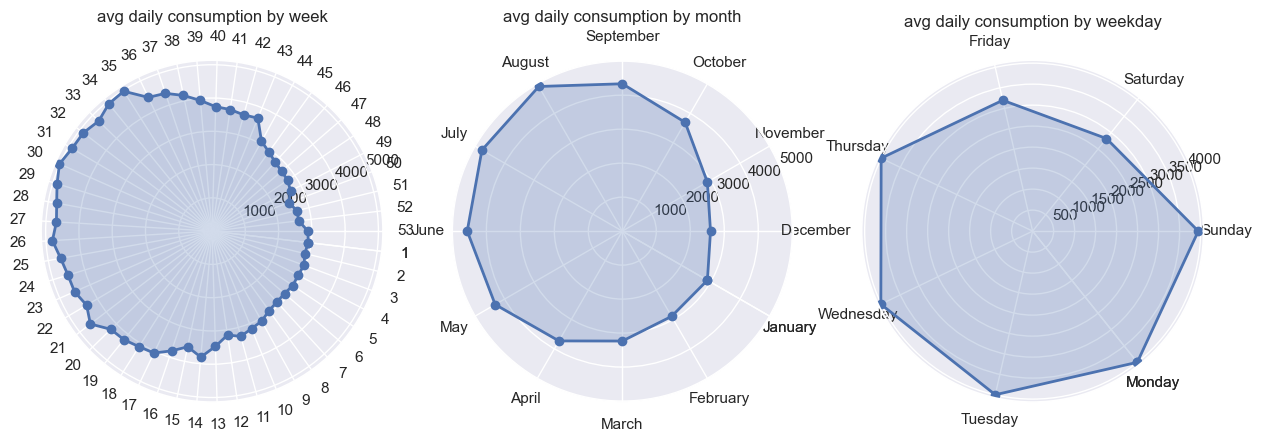

In [147]:

fig, axs = plt.subplots(figsize=(15, 5), nrows=1, ncols=3,
                            subplot_kw=dict(projection='polar'))
def radar_plt(stats, ax, title, labels=None):
    if not labels:
        labels = np.arange(1, len(stats)+1)
    angles=np.linspace(0, 2*np.pi, len(labels), endpoint=False)[::-1] # Set the angle
    stats=np.concatenate((stats,[stats[0]]))  # Closed
    angles=np.concatenate((angles,[angles[0]]))  # Closed
    ax.plot(angles, stats, 'o-', linewidth=2)  # Draw the plot (or the frame on the radar chart)
    ax.fill(angles, stats, alpha=0.25)  #Fulfill the area
    ax.set_thetagrids(angles * 180/np.pi, np.concatenate((labels, labels[:1])))  # Set the label for each axis
    ax.set_title(title)  # Set the pokemon's name as the title
    #ax.set_rlim(0,250)
    ax.grid(True)


stats=current.groupby(current.timestamp.dt.isocalendar().week).mean(numeric_only=True).total.values
radar_plt(stats, axs[0], 'avg daily consumption by week')
stats=current.groupby(current.timestamp.dt.month).mean(numeric_only=True).total.values
radar_plt(stats, axs[1], 'avg daily consumption by month',  ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December'] )
stats=current.groupby(current.timestamp.dt.day_of_week).mean(numeric_only=True).total.values
radar_plt(stats, axs[2], 'avg daily consumption by weekday', ('Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday','Sunday'))

<Axes: xlabel='weekday', ylabel='total'>

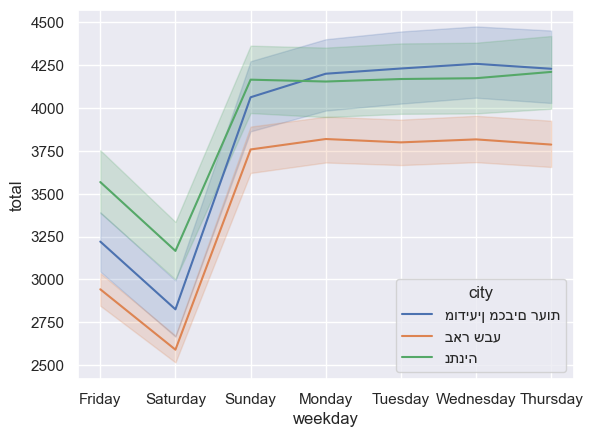

In [154]:
current['weekday'] = current.timestamp.dt.day_of_week.map(lambda x: ('Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday','Sunday')[x])
sns.lineplot(data=current, x='weekday', y='total', hue='city')